# LDDMM Vocal Tract Morphing
<br>
This notebook demonstrates the ability to morph from one vocal tract to another through the powerful technique of LDDMM. The LDDMM morphing was performed on tensors derived from each permutation of the three following phonetic sounds.

### Phonetic Sounds

- **aa**: /ɑː/
- **ll**: /l/
- **oo**: /uː/

The LDDMM implementation used took functions from the notebook "Geometry and shape space - TP3 - Construction of atlases and connections to geometric data". The tensors used were created from first decimating meshes for each phonetic sound to a mesh of 300 triangles, then performing a mesh to tensor conversion, taking each permutation of source and target mesh.

In [ ]:
# Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [16, 10]

import torch
from torch.autograd import grad

In [ ]:
# Functions from TP3 notebook to perform LDDMM

# noyau gaussien (K(x,y)b)_i = sum_j exp(-|xi-yj|^2)bj
def GaussKernel(sigma):
    oos2 = 1/sigma**2
    def K(x,y,b):
        return torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))@b
    return K

# solveur d'ODE
def RalstonIntegrator(nt=10):
    def f(ODESystem,x0,deltat=1.0):
        x = tuple(map(lambda x:x.clone(),x0))
        dt = deltat/nt
        for i in range(nt):
            xdot = ODESystem(*x)
            xi = tuple(map(lambda x,xdot:x+(2*dt/3)*xdot,x,xdot))
            xdoti = ODESystem(*xi)
            x = tuple(map(lambda x,xdot,xdoti:x+(.25*dt)*(xdot+3*xdoti),x,xdot,xdoti))
        return x
    return f

# définition du Hamiltonien H(p,q)
def Hamiltonian(K):
    def H(p,q):
        return .5*(p*K(q,q,p)).sum()
    return H

# système hamiltonien à résoudre pour le shooting
def HamiltonianSystem(K):
    H = Hamiltonian(K)
    def HS(p,q):
        Gp,Gq = grad(H(p,q),(p,q), create_graph=True)
        return -Gq,Gp
    return HS

# shooting = intégration du système hamiltonien
def Shooting(p0,q0,K,deltat=1.0,Integrator=RalstonIntegrator()):
    return Integrator(HamiltonianSystem(K),(p0,q0),deltat)

# intégration des équations de flot
def Flow(x0,p0,q0,K,deltat=1.0,Integrator=RalstonIntegrator()):
    # x0: contour points, p0,q0: output of the matching 
    HS = HamiltonianSystem(K)
    def FlowEq(x,p,q):
        return (K(x,q,p),)+HS(p,q)
    return Integrator(FlowEq,(x0,p0,q0),deltat)[0]

# définition de la fonctionnelle à minimiser
def LDDMMloss(q0,K,dataloss,gamma=0.):
    def loss(p0):
        p,q = Shooting(p0,q0,K)
        return gamma * Hamiltonian(K)(p0,q0) + dataloss(q)
    return loss



# méthode d'optimisation générique
def Optimize(loss,args,niter=5):
    optimizer = torch.optim.LBFGS(args)
    print('performing optimization...')
    for i in range(niter):
        print("iteration ",i+1,"/",niter)
        def closure():
            optimizer.zero_grad()
            L = loss(*args)
            L.backward()
            return L
        optimizer.step(closure)
    print("Done.")
    return args



# fonction d'affichage du résultat pour des données landmarks ou nuages de points
def PlotRes2D(z,pts=None):
    def plotfun(q0,p0,Kv):
        p,q = Shooting(p0,q0,Kv)
        q0np, qnp = q0.data.numpy(), q.data.numpy()
        q0np, qnp, znp = q0.data.numpy(), q.data.numpy(), z.data.numpy()
        plt.plot(znp[:,0],znp[:,1],'.');
        plt.plot(q0np[:,0],q0np[:,1],'+');
        plt.plot(qnp[:,0],qnp[:,1],'o');
        plt.axis('equal');
        ng = 50
        a = np.min(np.vstack((q0np[:,0],qnp[:,0])))
        b = np.max(np.vstack((q0np[:,0],qnp[:,0])))
        c = np.min(np.vstack((q0np[:,1],qnp[:,1])))
        d = np.max(np.vstack((q0np[:,1],qnp[:,1])))
        sz = 0.2
        lsp1 = np.linspace(a-sz*(b-a),b+sz*(b-a),ng,dtype=np.float32)
        lsp2 = np.linspace(c-sz*(d-c),d+sz*(d-c),ng,dtype=np.float32)
        X1, X2 = np.meshgrid(lsp1,lsp2)
        x = np.concatenate((X1.reshape(ng**2,1),X2.reshape(ng**2,1)),axis=1)
        phix = Flow(torch.from_numpy(x),p0,q0,Kv).detach().numpy()
        X1 = phix[:,0].reshape(ng,ng)
        X2 = phix[:,1].reshape(ng,ng)
        plt.plot(X1,X2,'k',linewidth=.25);
        plt.plot(X1.T,X2.T,'k',linewidth=.25); 
        n,d = q0.shape
        nt = 20
        Q = np.zeros((n,d,nt))
        for i in range(nt):
            t = i/(nt-1)
            Q[:,:,i] = Shooting(t*p0,q0,Kv)[1].data.numpy()
        plt.plot(Q[:,0,:].T,Q[:,1,:].T,'y');
        if type(pts)!=type(None):
            phipts = Flow(pts,p0,q0,Kv).data
            plt.plot(phipts.numpy()[:,0],phipts.numpy()[:,1],'.b',markersize=.1);
    return plotfun

# fonction d'affichage pour des données de type surface triangulée
def PlotResSurf(VS,FS,VT,FT):
    def plotfun(q0,p0,Kv):
        fig = plt.figure();
        plt.axis('off')
        plt.title('LDDMM matching example')  
        p,q = Shooting(p0,q0,Kv)
        q0np, qnp = q0.data.numpy(), q.data.numpy()
        FSnp,VTnp, FTnp = FS.data.numpy(),  VT.data.numpy(), FT.data.numpy()    
        ax = Axes3D(fig, auto_add_to_figure=False)
        ax.plot_trisurf(q0np[:,0],q0np[:,1],q0np[:,2],triangles=FSnp,alpha=.5)
        ax.plot_trisurf(qnp[:,0],qnp[:,1],qnp[:,2],triangles=FSnp,alpha=.5)
        ax.plot_trisurf(VTnp[:,0],VTnp[:,1],VTnp[:,2],triangles=FTnp,alpha=.5)
        fig.add_axes(ax)
    return plotfun

# fonction d'attache aux données pour des landmarks
def losslmk(z):
    def loss(q):
        return ((q-z)**2).sum()
    return loss

# fonction d'attache aux données pour des nuages de points via le modèle des mesures
def lossmeas(z,Kw):
    nz = z.shape[0]
    wz = torch.ones(nz,1)
    cst = (1/nz**2)*Kw(z,z,wz).sum()
    def loss(q):
        nq = q.shape[0]
        wq = torch.ones(nq,1)
        return cst + (1/nq**2)*Kw(q,q,wq).sum() + (-2/(nq*nz))*Kw(q,z,wz).sum()
    return loss


# noyau pour les varifolds (K(x,y,u,v)b)_i = sum_j exp(-|xi-yj|^2) <ui,vj>^2 bj
def GaussLinKernel(sigma,lib="keops"):
    oos2 = 1/sigma**2
    def K(x,y,u,v,b):
        Kxy = torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))
        Sxy = torch.sum(u[:,None,:]*v[None,:,:],dim=2)**2
        return (Kxy*Sxy)@b
    return K

# fonction d'attache aux données pour les surfaces triangulées, modèle des varifolds
# VT: coordonnées des points de la surface cible
# FS,FT : indices des triangles des surfaces source et cible
# K : noyau varifold
def lossVarifoldSurf(FS,VT,FT,K):
    def CompCLNn(F,V):
        V0, V1, V2 = V.index_select(0,F[:,0]), V.index_select(0,F[:,1]), V.index_select(0,F[:,2])
        C, N = .5*(V0+V1+V2), .5*torch.cross(V1-V0,V2-V0)
        L = (N**2).sum(dim=1)[:,None].sqrt()
        return C,L,N/L
    CT,LT,NTn = CompCLNn(FT,VT)
    cst = (LT*K(CT,CT,NTn,NTn,LT)).sum()
    def loss(VS):
        CS,LS,NSn = CompCLNn(FS,VS)
        return cst + (LS*K(CS,CS,NSn,NSn,LS)).sum() - 2*(LS*K(CS,CT,NSn,NTn,LT)).sum()
    return loss

# fonction similaire pour les courbes
def lossVarifoldCurve(FS, VT, FT, K):
    def get_center_length_tangents(F, V):
        V0, V1 = V.index_select(0, F[:, 0]), V.index_select(0, F[:, 1])
        centers, tangents = .5*(V0+V1), V1-V0
        length = (tangents**2).sum(dim=1)[:, None].sqrt()
        return centers, length, tangents / length
    CT, LT, TTn = get_center_length_tangents(FT, VT)
    cst = (LT * K(CT, CT, TTn, TTn, LT)).sum()
    def loss(VS):
        CS, LS, TSn = get_center_length_tangents(FS, VS)
        return cst + (LS * K(CS, CS, TSn, TSn, LS)).sum() - 2 * (LS * K(CS, CT, TSn, TTn, LT)).sum()
    return loss

In [ ]:
# Routine to perform LDDMM morphing for a given tensor

def lddmm_transformation_plotting(filename):
        VS,FS,VT,FT = torch.load(filename)
        # s: source, t: target, vs: vertices, f: faces
        # downsample to a manageable amount of traingles
        VS.requires_grad = True
        q0 = VS
        Kv = GaussKernel(sigma=20)   # parameter: typical length scale of data (adjust as required)
        Dataloss = lossVarifoldSurf(FS,VT,FT,GaussLinKernel(sigma=20))
        loss = LDDMMloss(q0,Kv,Dataloss)
        p0 = torch.zeros(q0.shape, requires_grad=True)
        p0, = Optimize(loss,[p0])

        # affichage du résultat
        plotfun = PlotResSurf(VS,FS,VT,FT)
        plotfun(q0,p0,Kv)
        plt.show()

1) aa to ll

C:\Users\Nova\AppData\Local\Temp\ipykernel_29808\2437060174.py:36: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Cross.cpp:66.)
  C, N = .5*(V0+V1+V2), .5*torch.cross(V1-V0,V2-V0)


performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


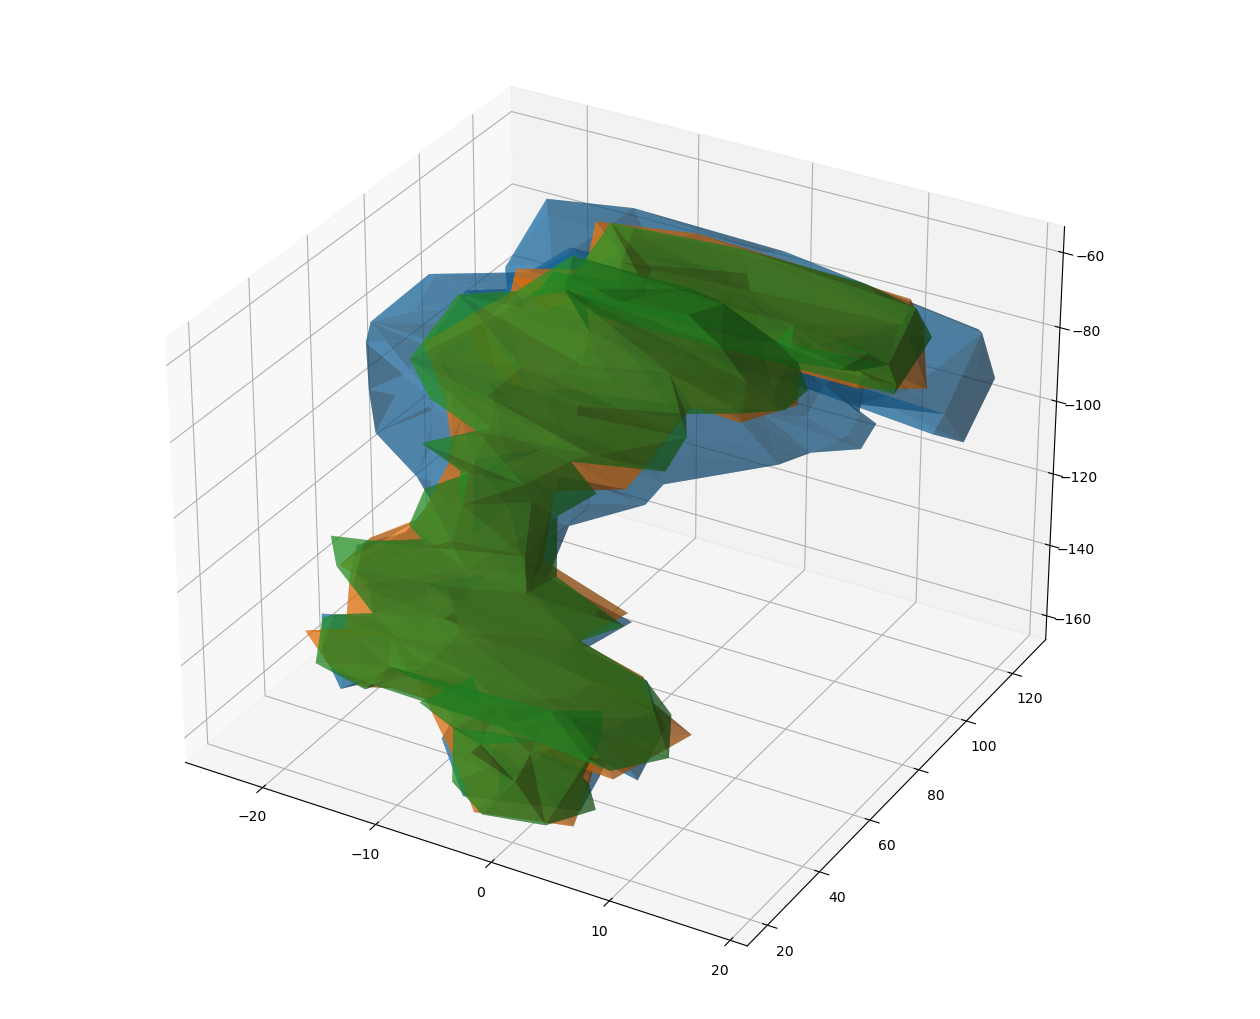

In [5]:
lddmm_transformation_plotting('tensors/aa_ll_mesh_300.pt')

2) ll to aa

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


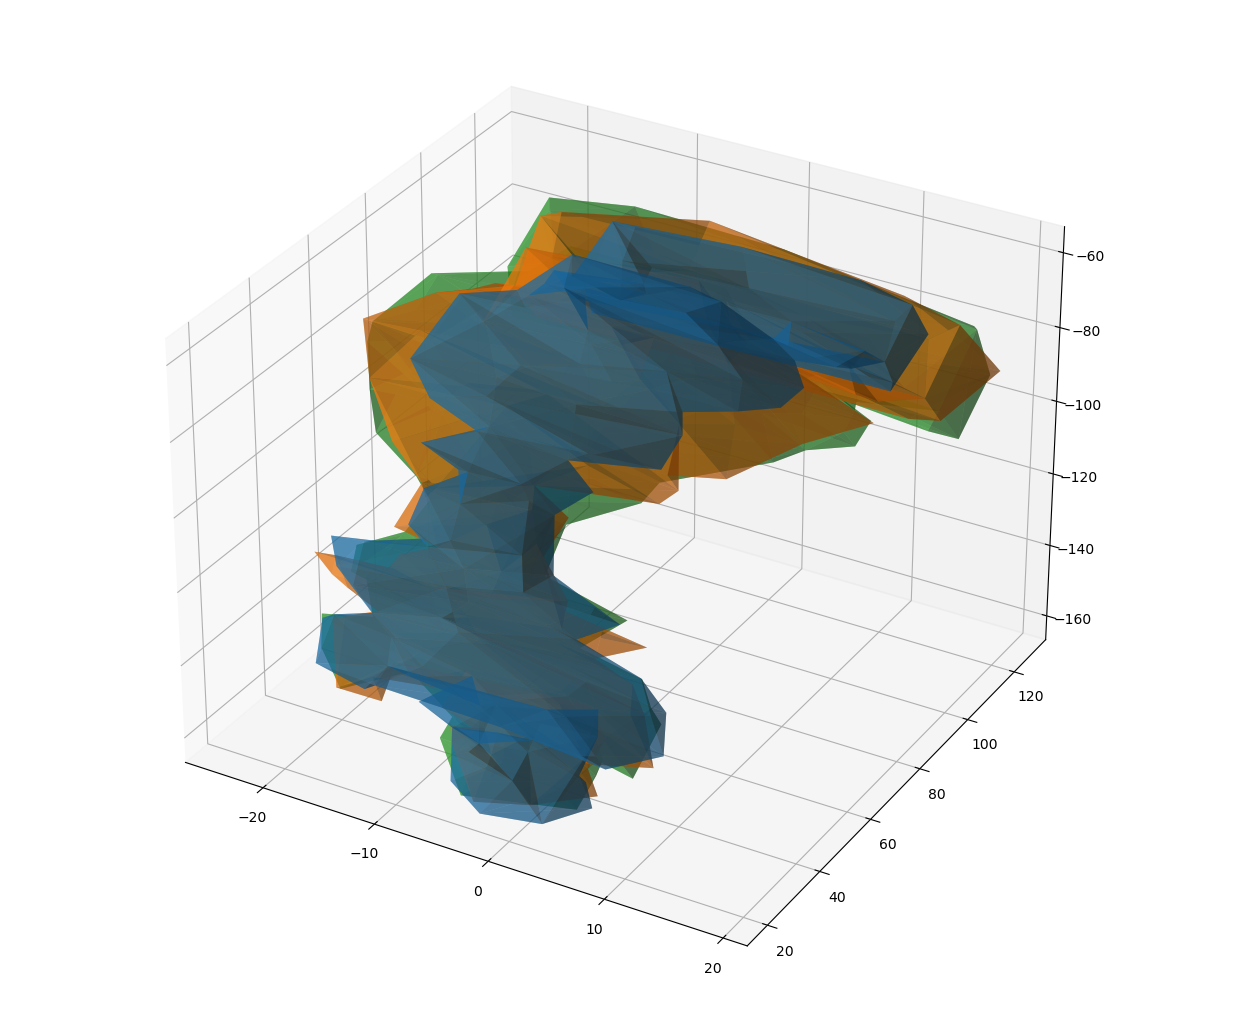

In [6]:
lddmm_transformation_plotting('tensors/ll_aa_mesh_300.pt')

3) aa to oo

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


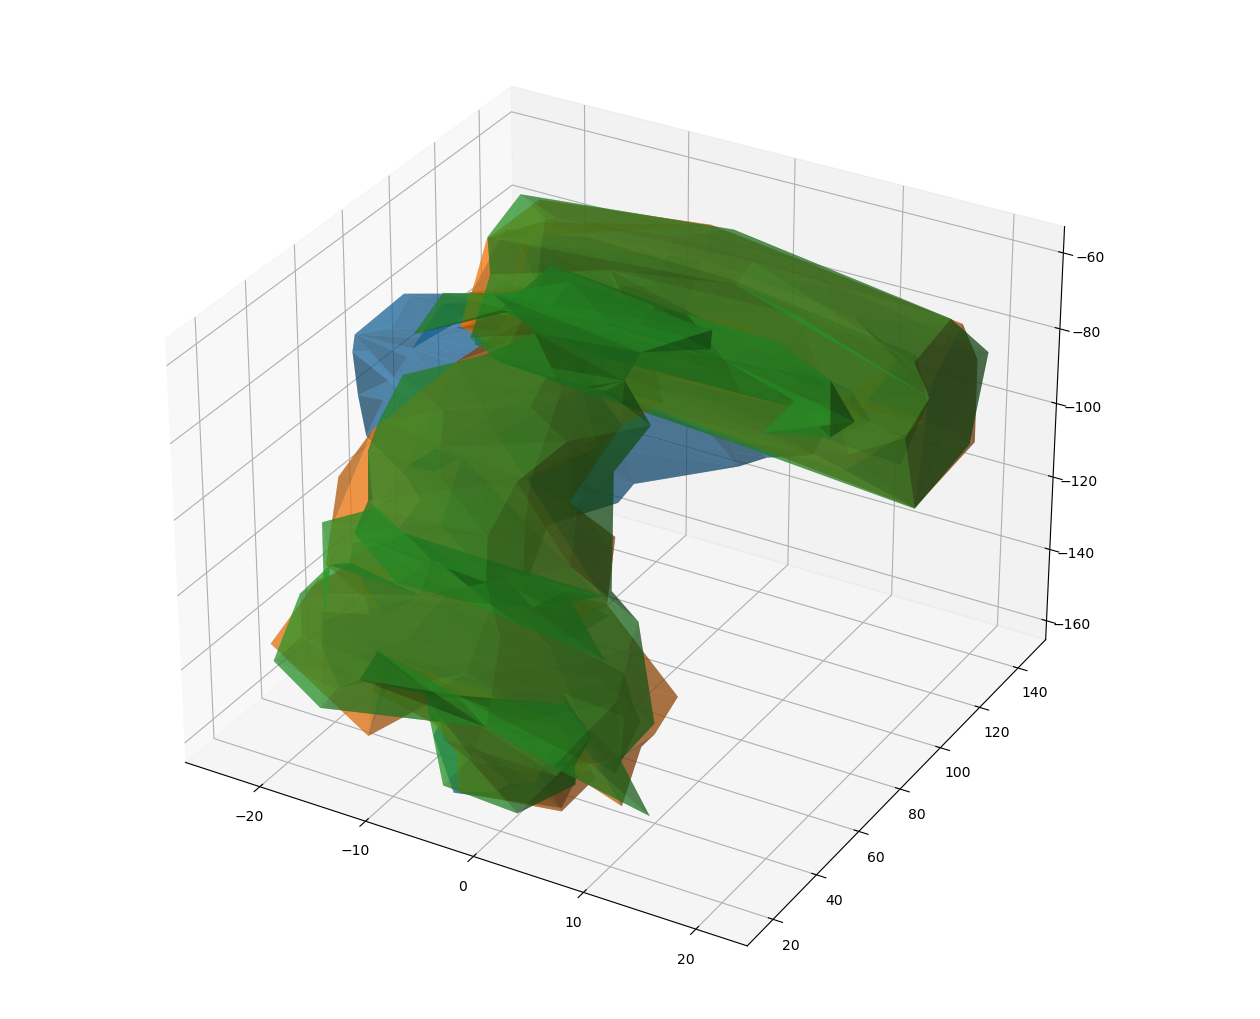

In [7]:
lddmm_transformation_plotting('tensors/aa_oo_mesh_300.pt')

4) oo to aa

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


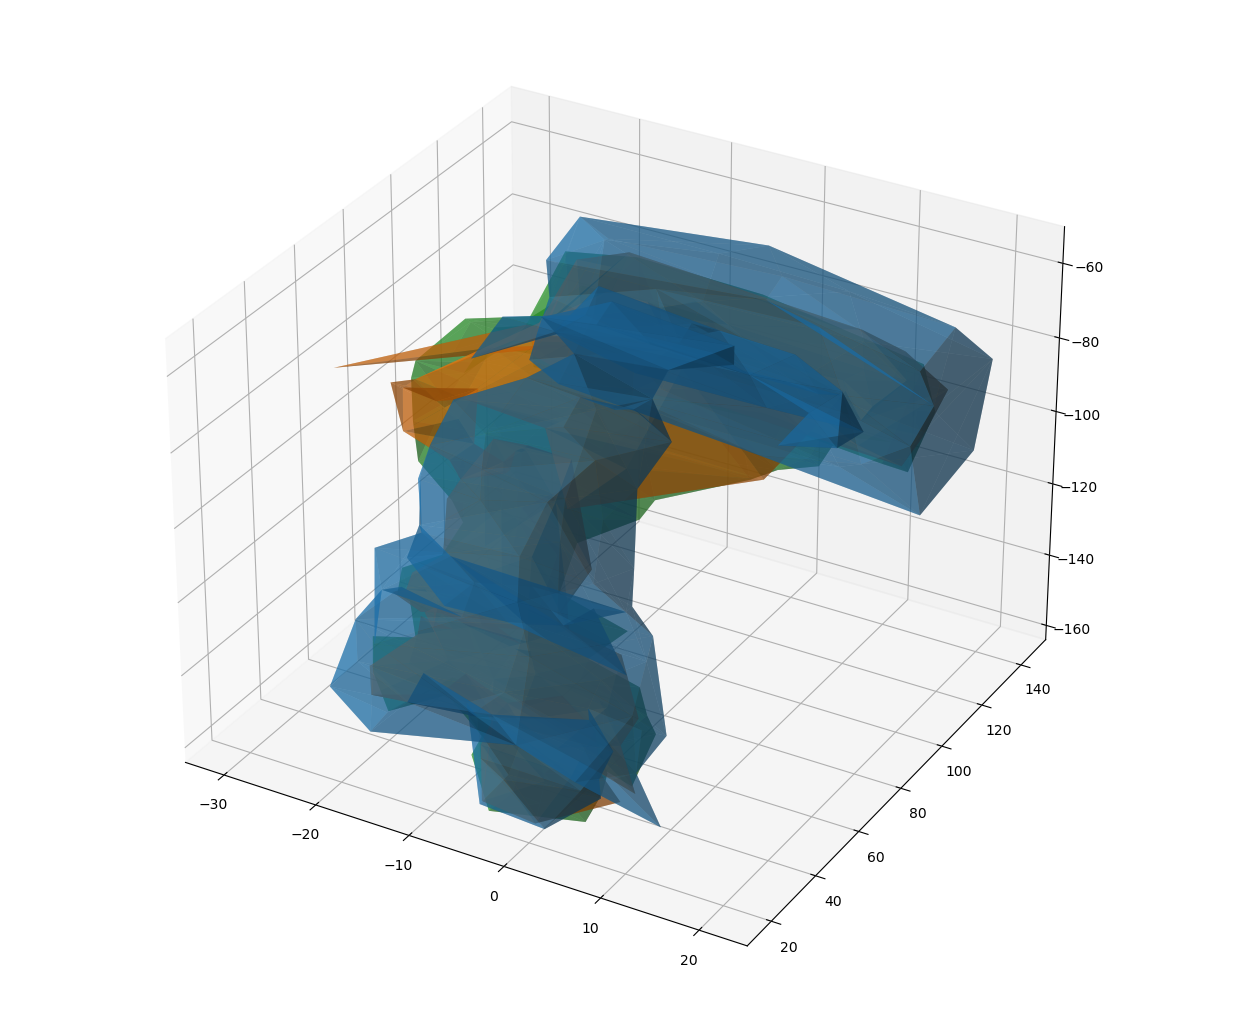

In [8]:
lddmm_transformation_plotting('tensors/oo_aa_mesh_300.pt')

5) ll to oo

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


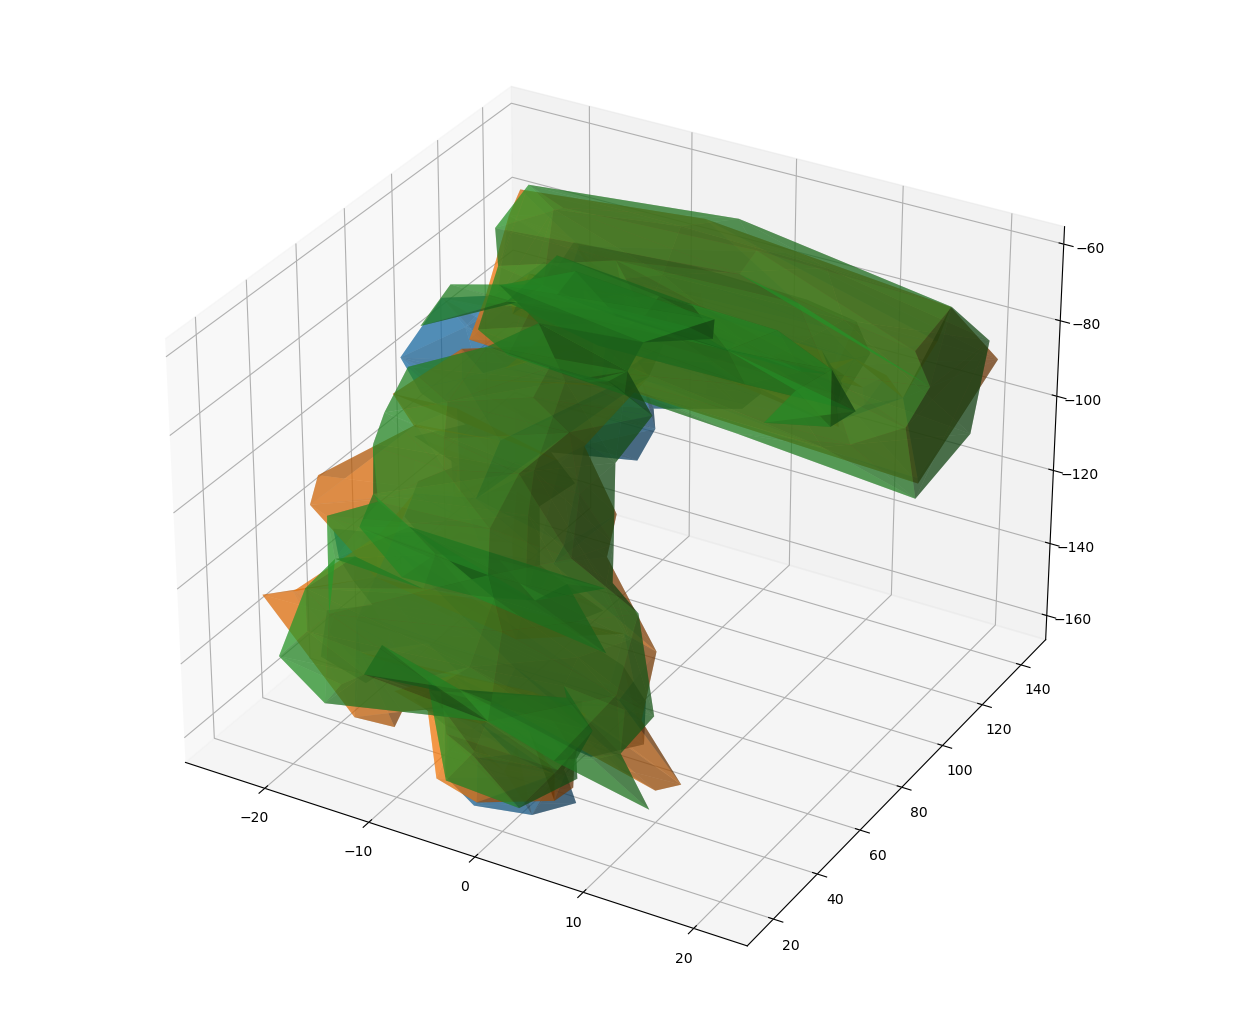

In [9]:
lddmm_transformation_plotting('tensors/ll_oo_mesh_300.pt')

6) oo to ll

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


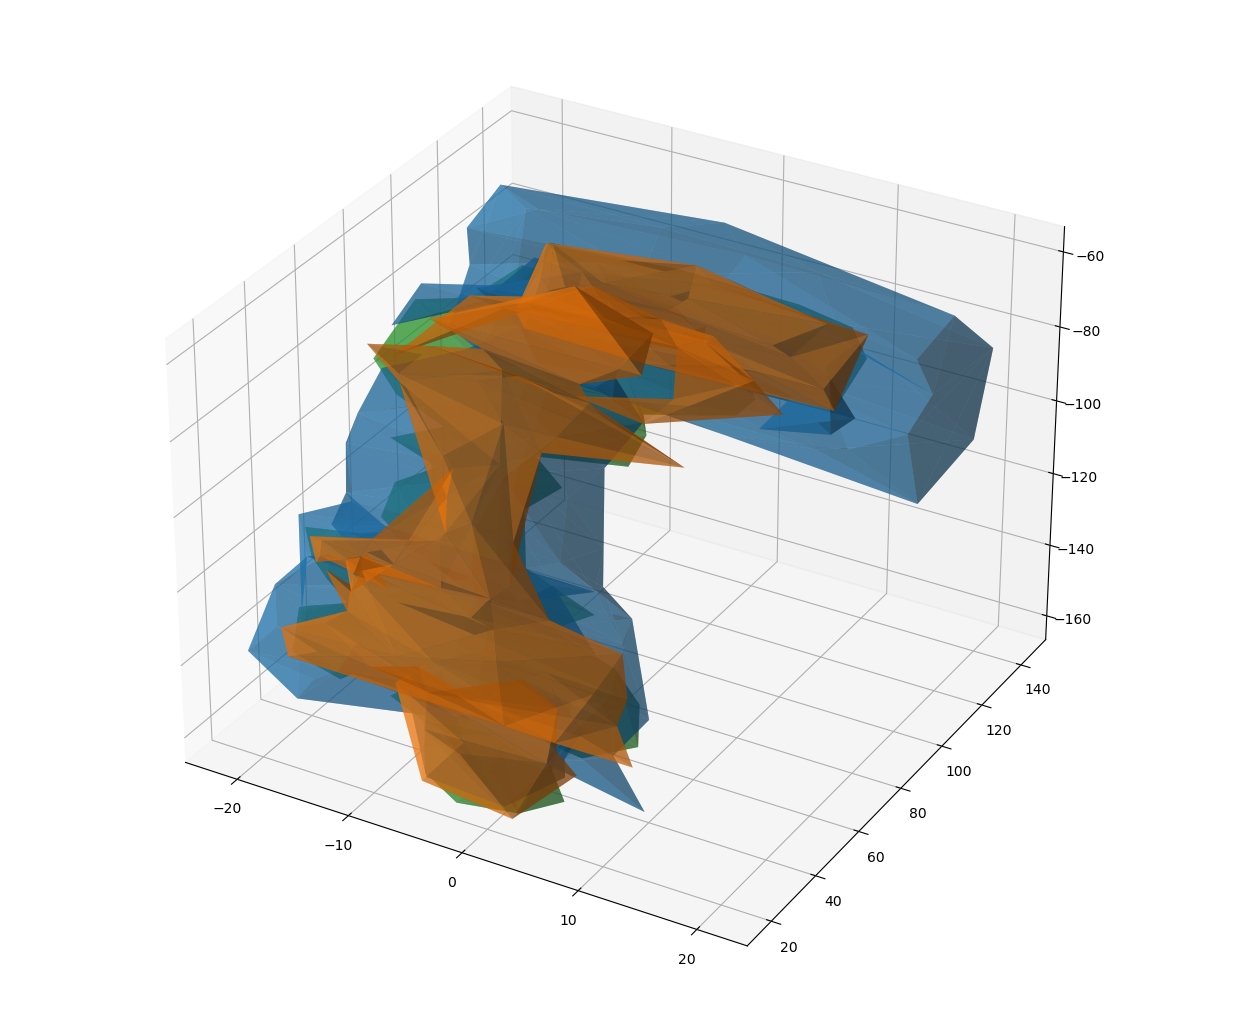

In [10]:
lddmm_transformation_plotting('tensors/oo_ll_mesh_300.pt')
